Compare photometry based on M6 proxies to the T-1 photometry

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.convolution import convolve, Box1DKernel, convolve_fft, Gaussian1DKernel
import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from astropy.time import Time
from scipy.optimize import leastsq
from scipy.stats import chisquare

from astropy.modeling.models import custom_model

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

4.7625748853059357e-17 4.687123024201185e-18 3.29753147097535e-18 3.291278334269941e-18 2.0041570552963399e-19 1.866306096537357e-19
4.709977014621346e-17 4.5316798905666145e-18 3.282795214017994e-18 4.114500703837729e-18 1.9679684412744362e-19 1.855241119922278e-19
3.742078227266277e-17 3.822203597025791e-18 2.8488357373977445e-18 3.231238607826323e-18 2.375734881995256e-19 1.643265608372743e-19


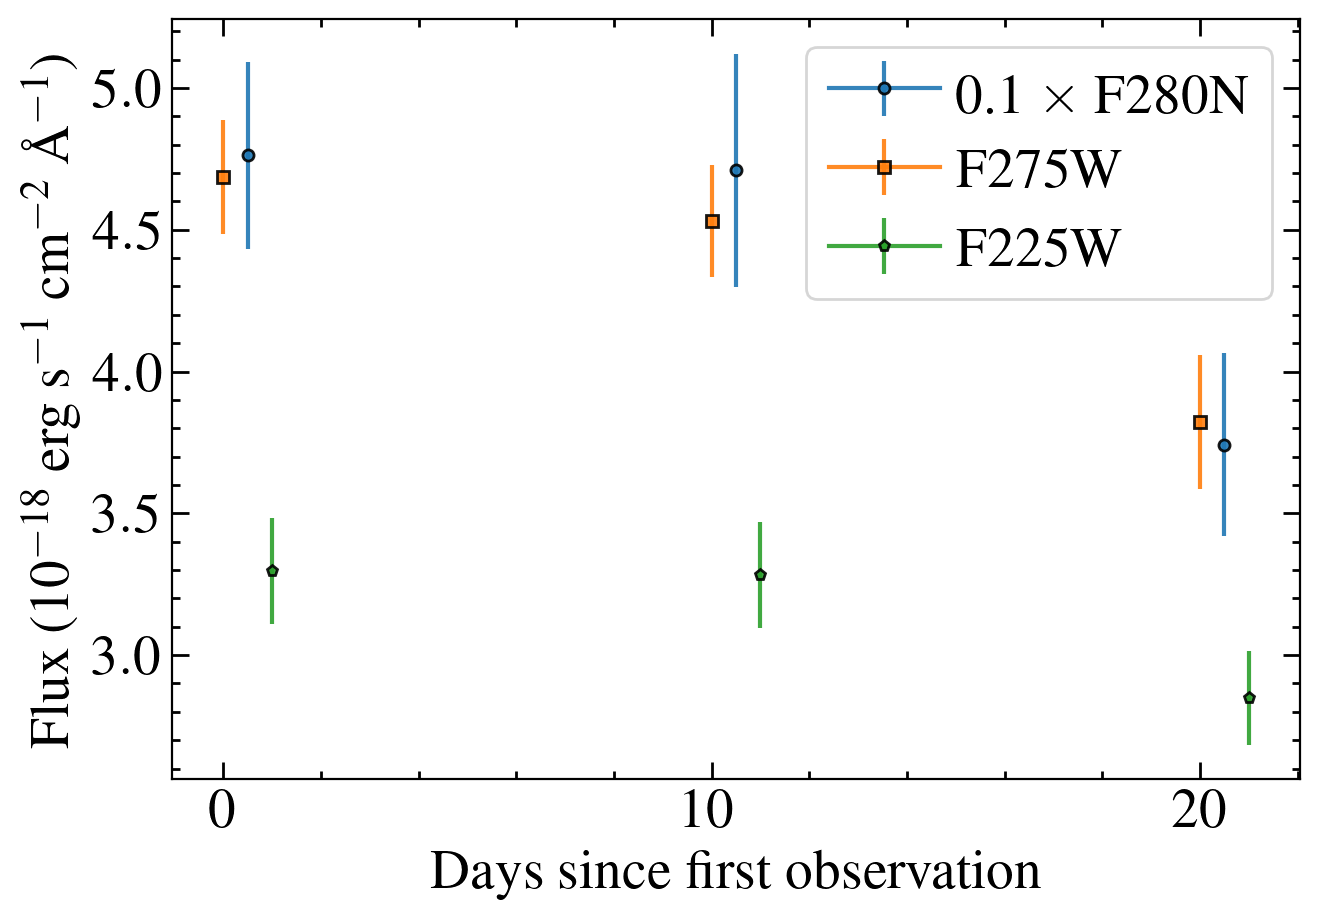

In [2]:
wfc3 = glob.glob('results/*wfc3_p*')
wfc3.sort()
# wfc3
crs = ['if3i03z2q', 'if3i03zcq']

phot_w = np.array([2358.7, 2713.86, 2796.94])

fig, ax = plt.subplots(figsize=(7, 5))
scale = 1e18

#2023-06-20, 2023-06-30, 2023-07-10 
days = [0, 10, 20]

# cols = [0, 1, 2]

f280n_avs = []
f280n_aves = []
f275w_avs = []
f275w_aves = []
f225w_avs = []
f225w_aves = []



for i, phot in enumerate(wfc3):
    data = Table.read(phot)
    
    f280n = []
    f275w = []
    f225w= []
    f280n_e = []
    f275w_e = []
    f225w_e= []
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
                f280n.append(row['FLUX'])
                f280n_e.append(row['ERROR'])
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
                f275w.append(row['FLUX'])
                f275w_e.append(row['ERROR'])
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'
                f225w.append(row['FLUX'])
                f225w_e.append(row['ERROR'])

    f280n ,f275w, f225w,f280n_e, f275w_e, f225w_e = np.array(f280n) ,np.array(f275w), np.array(f225w),np.array(f280n_e), np.array(f275w_e), np.array(f225w_e)
    
    if i == 0:
        f225w, f225w_e = f225w[:-1], f225w_e[:-1] #exclude outliers
        
    if i == 2:
        f275w, f275w_e = f275w[1:], f275w_e[1:] #exclude outliers
    
    f280n_av = np.average(f280n, weights = 1/(f280n_e**2))
    f280n_ave = (1/(np.sum(1/(f280n_e**2))))**0.5
    ax.errorbar(days[i]+0.5, f280n_av*scale/10, yerr=f280n_ave*scale/10, marker='o', c='C0', label = r'0.1 $\times$ F280N',  markeredgecolor='k', markersize=4, alpha=0.9)
        
#     if i == 2:
#         f275w_av = np.average(f275w[1:], weights = 1/(f275w_e[1:]**2))
#         f275w_ave = (1/(np.sum(1/(f275w_e[1:]**2))))**0.5
    
#     else:
    f275w_av = np.average(f275w, weights = 1/(f275w_e**2))
    f275w_ave = (1/(np.sum(1/(f275w_e**2))))**0.5
    ax.errorbar(days[i], f275w_av*scale, yerr=f275w_ave*scale, marker='s', c='C1', label='F275W',  markeredgecolor='k', markersize=4, alpha=0.9)
    
    f225w_av = np.average(f225w, weights = 1/(f225w_e**2))
    f225w_e = np.full(len(f225w), f225w_e[0])
    f225w_ave = (1/(np.sum(1/(f225w_e**2))))**0.5
    ax.errorbar(days[i]+1, f225w_av*scale, yerr=f225w_ave*scale, marker='p', c='C2', label = 'F225W',  markeredgecolor='k', markersize=4, alpha=0.9)
    
    print(f280n_av ,f275w_av, f225w_av,f280n_ave, f275w_ave, f225w_ave)
    
    f280n_avs.append(f280n_av)
    f280n_aves.append(f280n_ave)
    f275w_avs.append(f275w_av)
    f275w_aves.append(f275w_ave)
    f225w_avs.append(f225w_av)
    f225w_aves.append(f225w_ave)
    
#     print(f280n_av/f275w_av)
#     print(f280n_av/f225w_av)

            
        
            
#         if row['FILTER'] == 'F280N':
#             ax.errorbar(days[i], row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
#                         marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
#         else:
#             ax.errorbar(days[i], row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)




# ax.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.5, c='C0')
# ax.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.5, c='C1')
# ax.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.5, c='C2')
        
# ax.set_yscale('log')
ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Days since first observation')
ax.set_xticks(days)

# ax.set_xlim(-4, 49)
# ax.set_ylim(2.1, 7.9)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

fig.tight_layout()
# fig.savefig('plots/wfc3_average_visits.pdf')

['filters/HST_WFC3_UVIS2.F225W.dat', 'filters/HST_WFC3_UVIS2.F275W.dat', 'filters/HST_WFC3_UVIS2.F280N.dat']
filters/HST_WFC3_UVIS2.F225W.dat
1990.0 3477.0
filters/HST_WFC3_UVIS2.F275W.dat
2150.676514 3250.0
filters/HST_WFC3_UVIS2.F280N.dat
2751.513428 2887.0


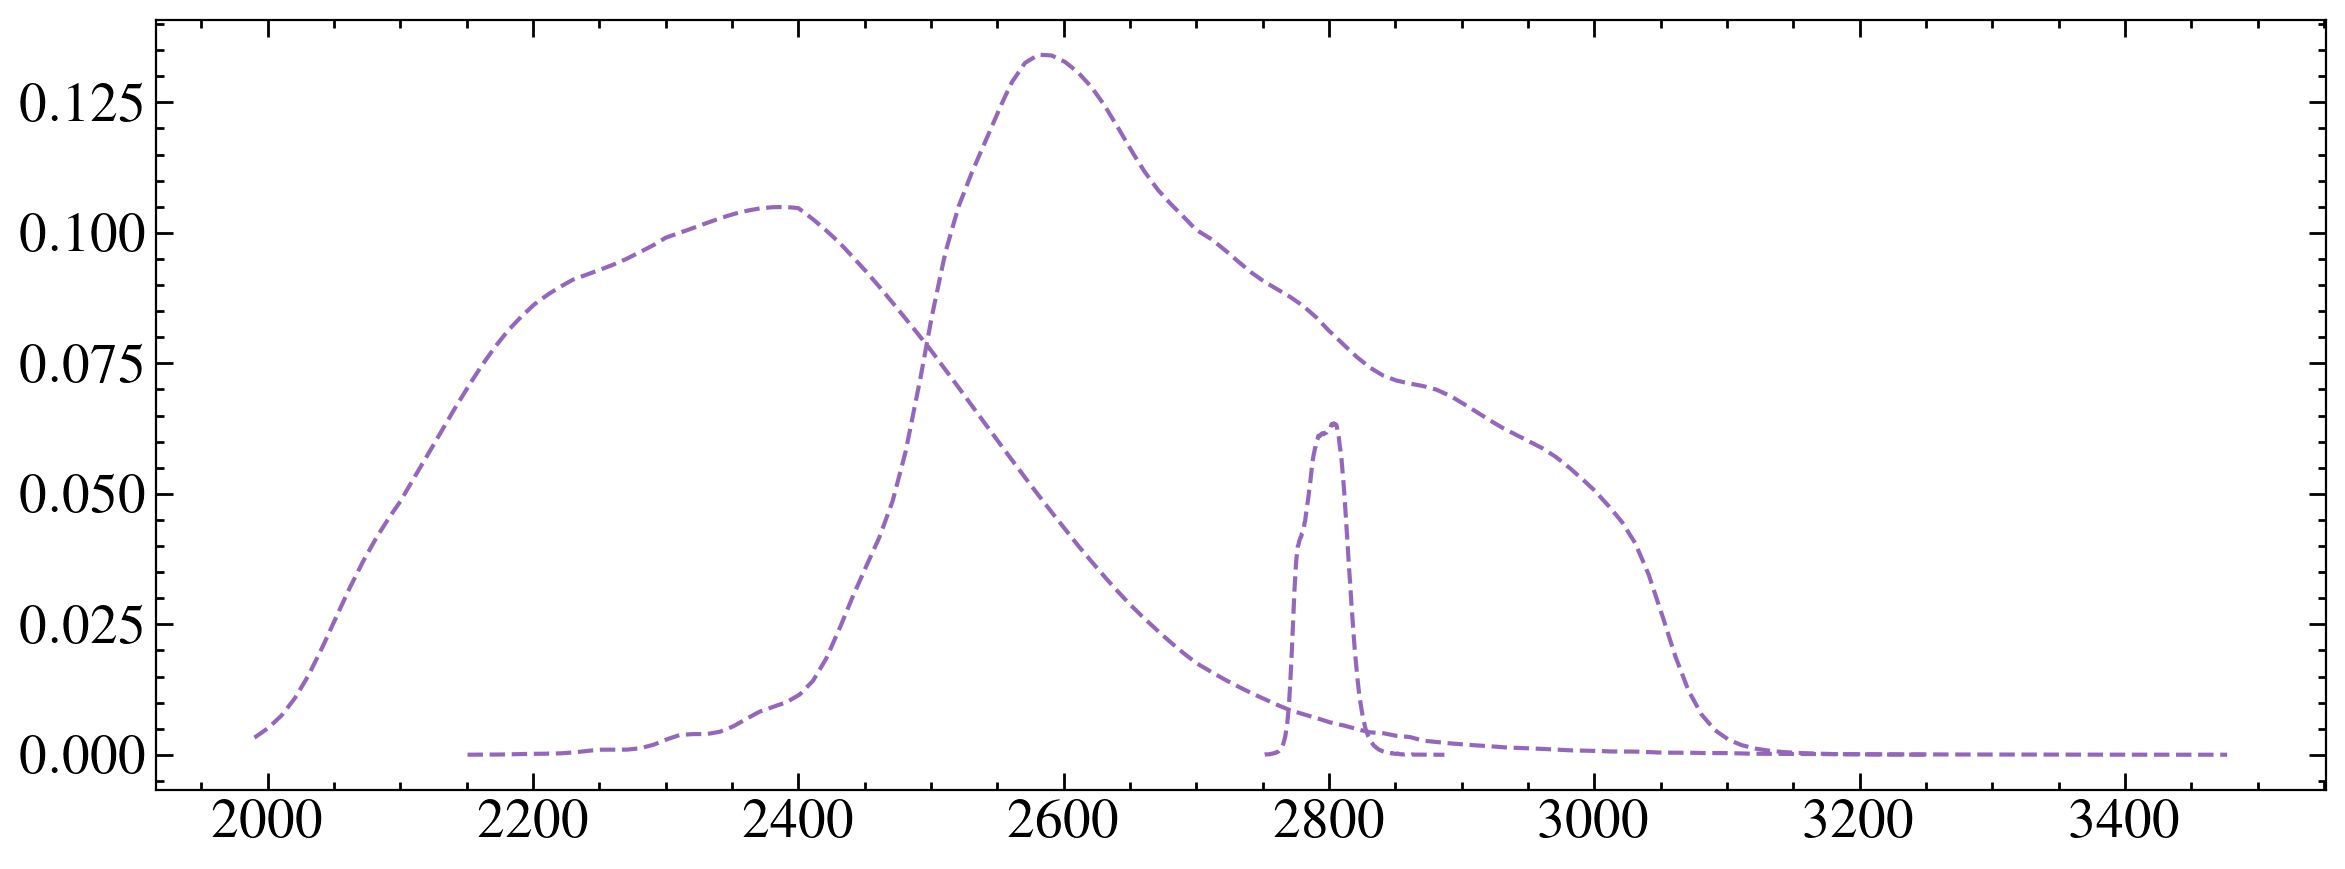

In [3]:
bpws = []
bpfs = []

wbands= glob.glob('filters/*UVIS*')
wbands.sort()
print(wbands)
for band in wbands:
    print(band)
    bpw, bpf = np.loadtxt(band, unpack=True)
    plt.plot(bpw, bpf, ls ='--', c='C4', label = 'Transmission Profiles')
    bpws.append(bpw)
    bpfs.append(bpf)
    print(bpw[0], bpw[-1])

# print(bpws)

In [4]:
def make_phot(bp_w, bp_cc, w, f, e=0):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    flux = np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)
    if isinstance(e, int) != True:
        e = e[mask]
        intf = np.trapz(f, w)
        inte = (np.sum(e[1:]**2 * np.diff(w)**2))**0.5
        flux_error = (inte/intf)*flux
        return flux, flux_error
    else:
        return flux 

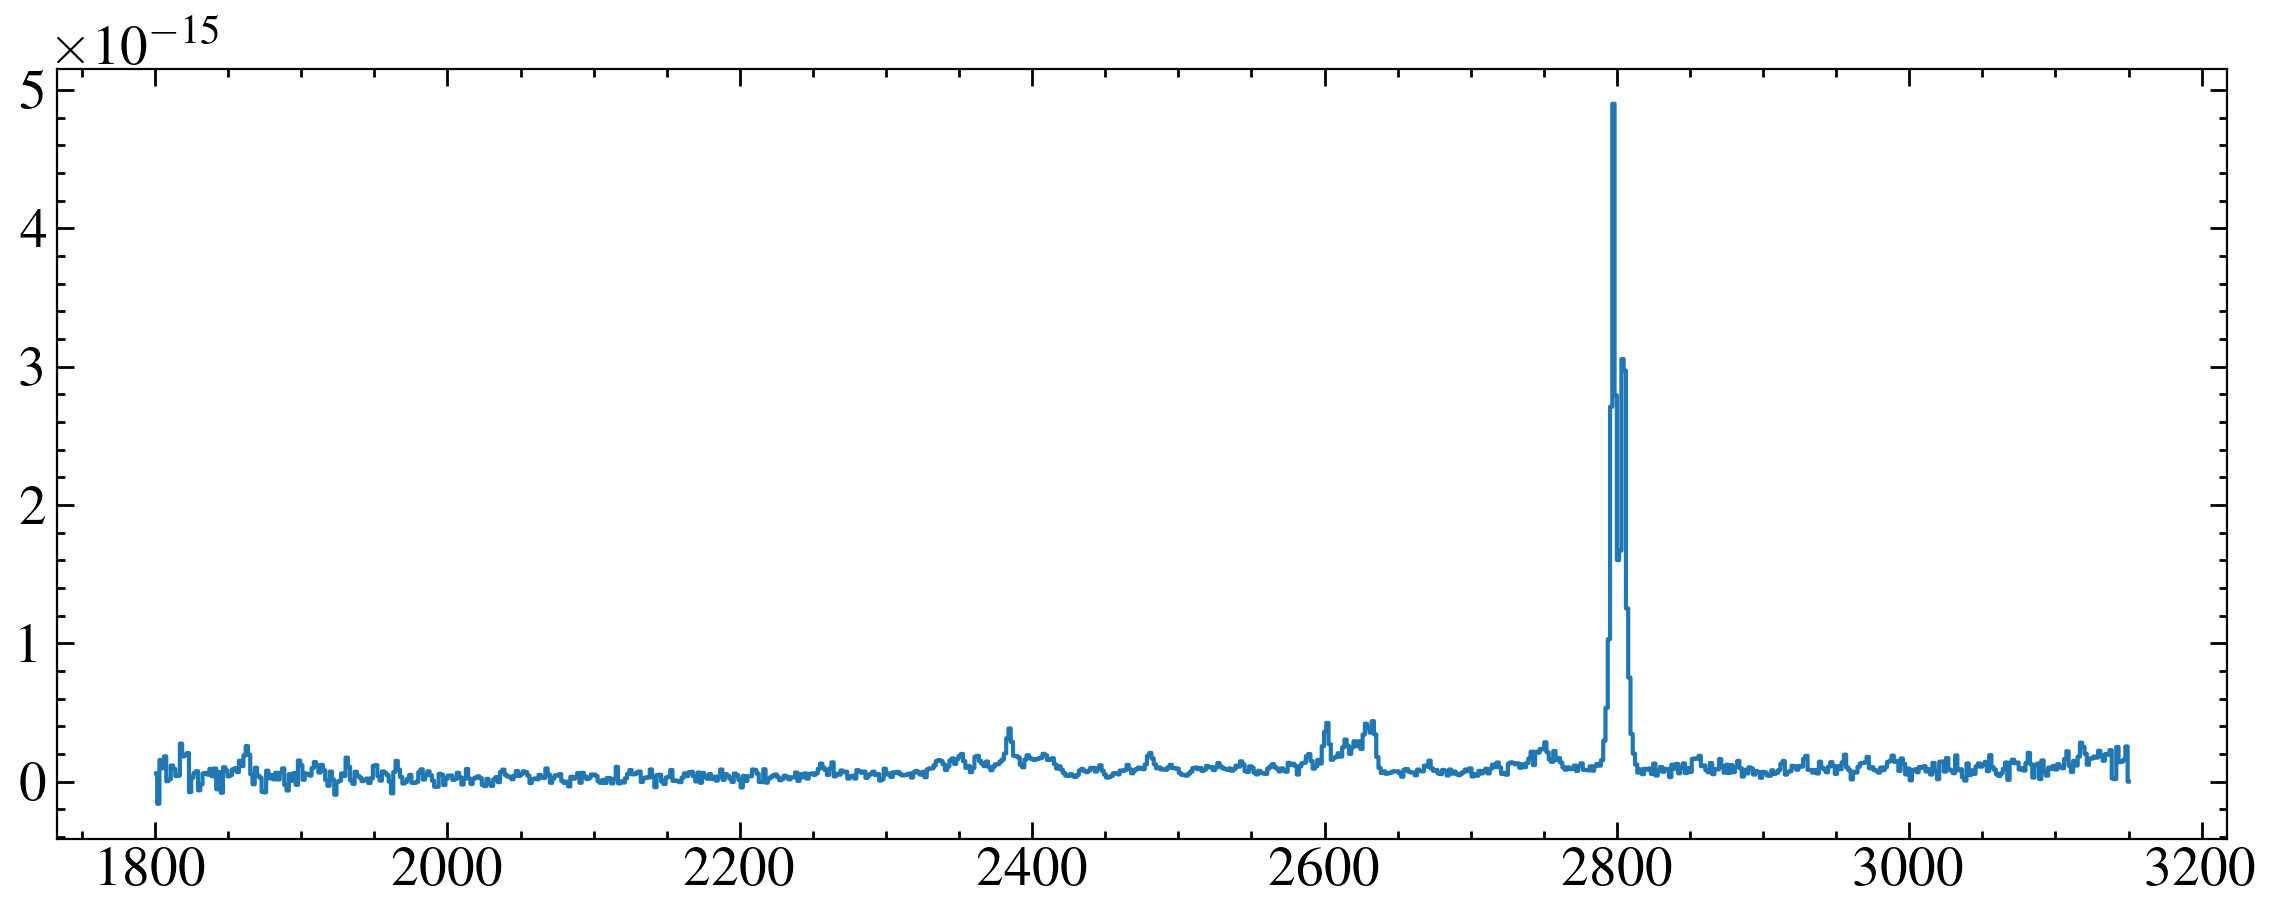

In [5]:
proxpath ='/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/'
proxys = ['hlsp_muscles_hst_stis_lp-791-18_g230l_v23_component-spec.fits', 'hlsp_muscles_hst_stis_lhs-2686_g230l_v23_component-spec.fits']

for prox in proxys[1:]:
    fig, ax = plt.subplots()
    data = fits.getdata('{}{}'.format(proxpath, prox))
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1800
    w, f, e = w[mask], f[mask], e[mask]
    ax.step(w, f, where='mid')
    # plt.step(w, e, where='mid', alpha =0.2)
    # plt.yscale('log')

wx, fx, ex = w, f, e

urgh non detection for the MEATS one. LHS 2686 it is.

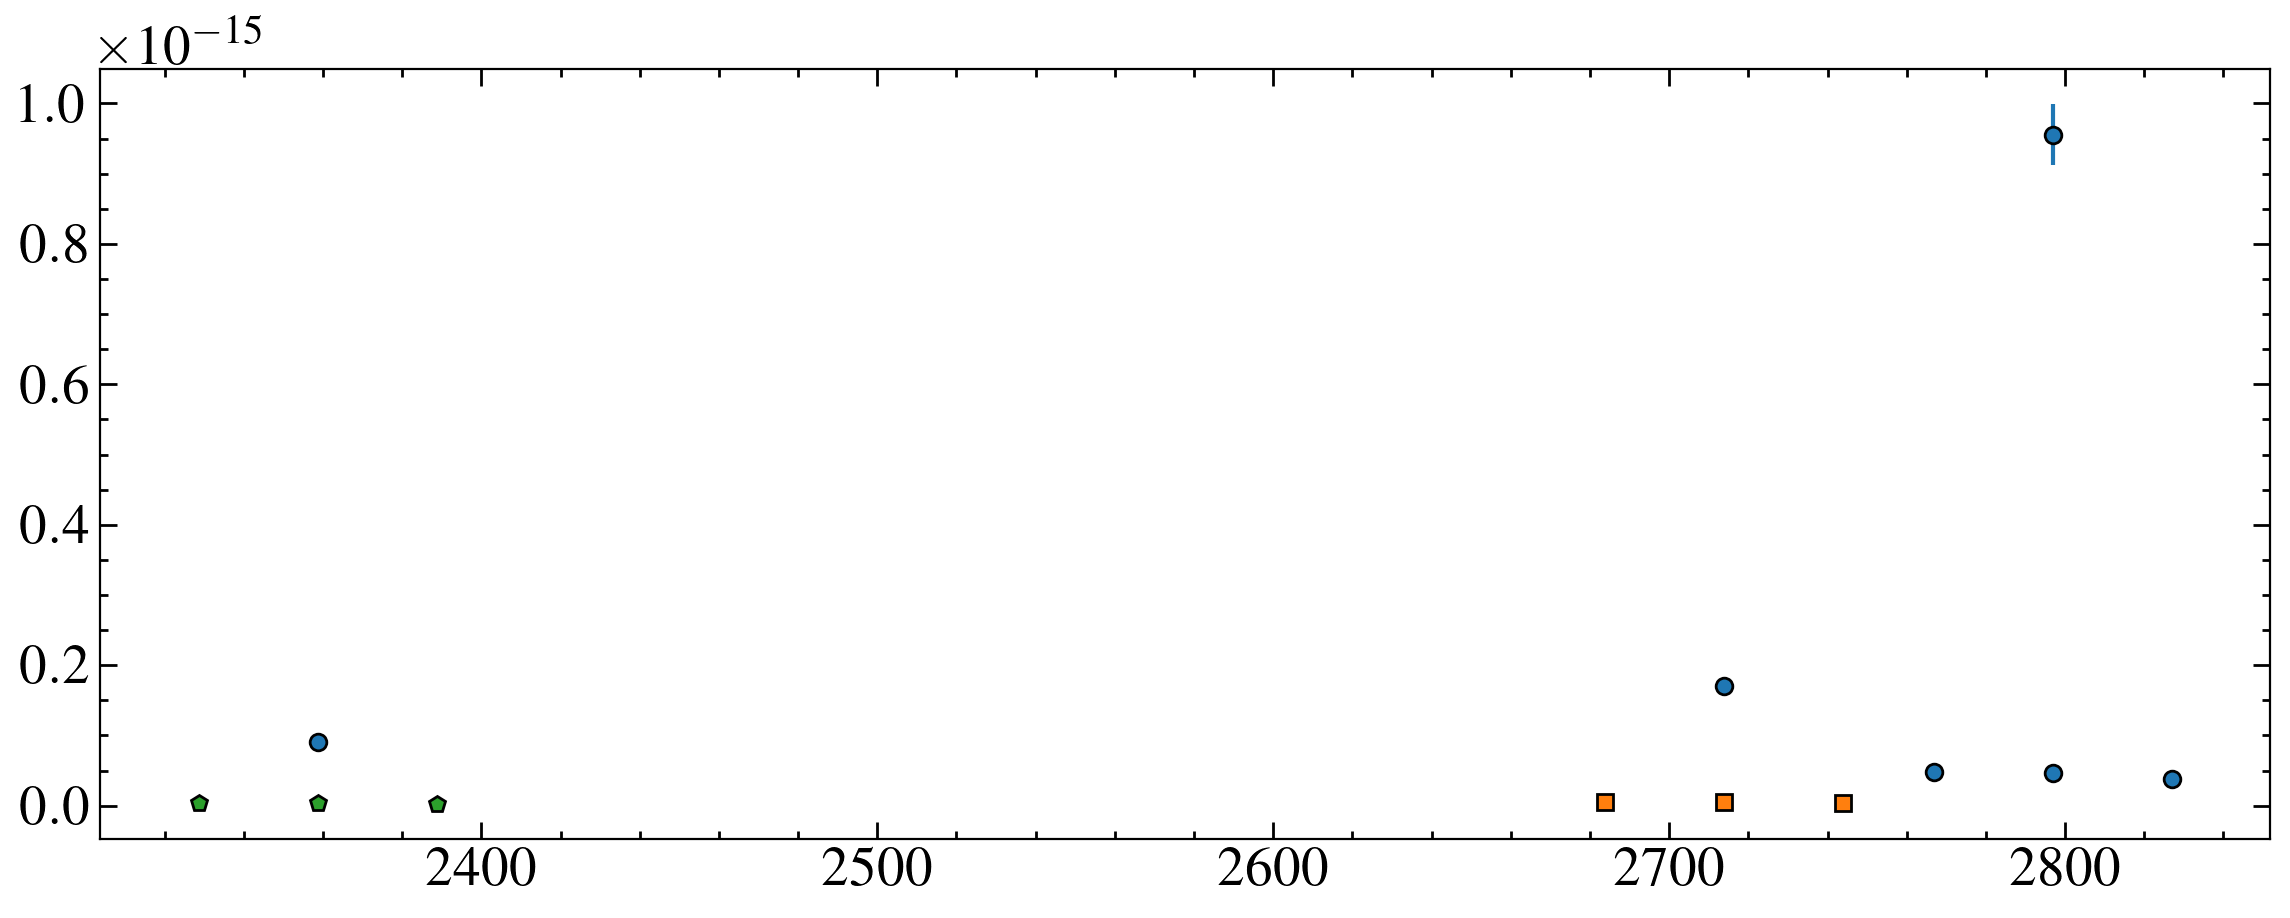

In [6]:
prox_phots = []
prox_phot_e = []


for bpw, bpf in zip(bpws, bpfs):
    phot, phote = make_phot(bpw, bpf, wx, fx, e=ex)
    prox_phots.append(phot)
    prox_phot_e.append(phote)

prox_phots, prox_phot_e = np.array(prox_phots), np.array(prox_phot_e)

fig, ax = plt.subplots()

ax.errorbar(phot_w, prox_phots, yerr=prox_phot_e, marker='o', ls='none', markeredgecolor='k', label = 'LHS-2686', zorder=12)
markers = np.array(['p', 's', 'o'])

for i in range(3):


    # fig, ax = plt.subplot_mosaic([[0, 0, 0],[0,0,0], [1,1,1], [2,2,2], [2,2,2], [3,3,3]], sharex=True, figsize=(12, 10))
    phot_f = np.array([f225w_avs[i], f275w_avs[i], f280n_avs[i]])
    phot_e = np.array([f225w_aves[i], f275w_aves[i], f280n_aves[i]])


    
    for j in range(3):
        # ax.errorbar(phot_w+((i-1)*30), phot_f, yerr=phot_e, marker=marker, ls='none', markeredgecolor='k', label = 'WFC3', zorder=12)
        ax.errorbar(phot_w[j]+((i-1)*30), phot_f[j], yerr=phot_e[j], marker=markers[j], ls='none', markeredgecolor='k', label = 'WFC3', zorder=12, c='C{}'.format(2-j))




[0.03612755 0.02756356 0.04983416]
1.3106998028831178 0.7249555322673314 1.807972688730086
[0.0359661  0.02664944 0.04928379]
1.3496004203507663 0.7297754353270509 1.8493365972861762
[0.03121167 0.02247723 0.03915599]
1.3885906276534414 0.7971109652602947 1.7420292633912022


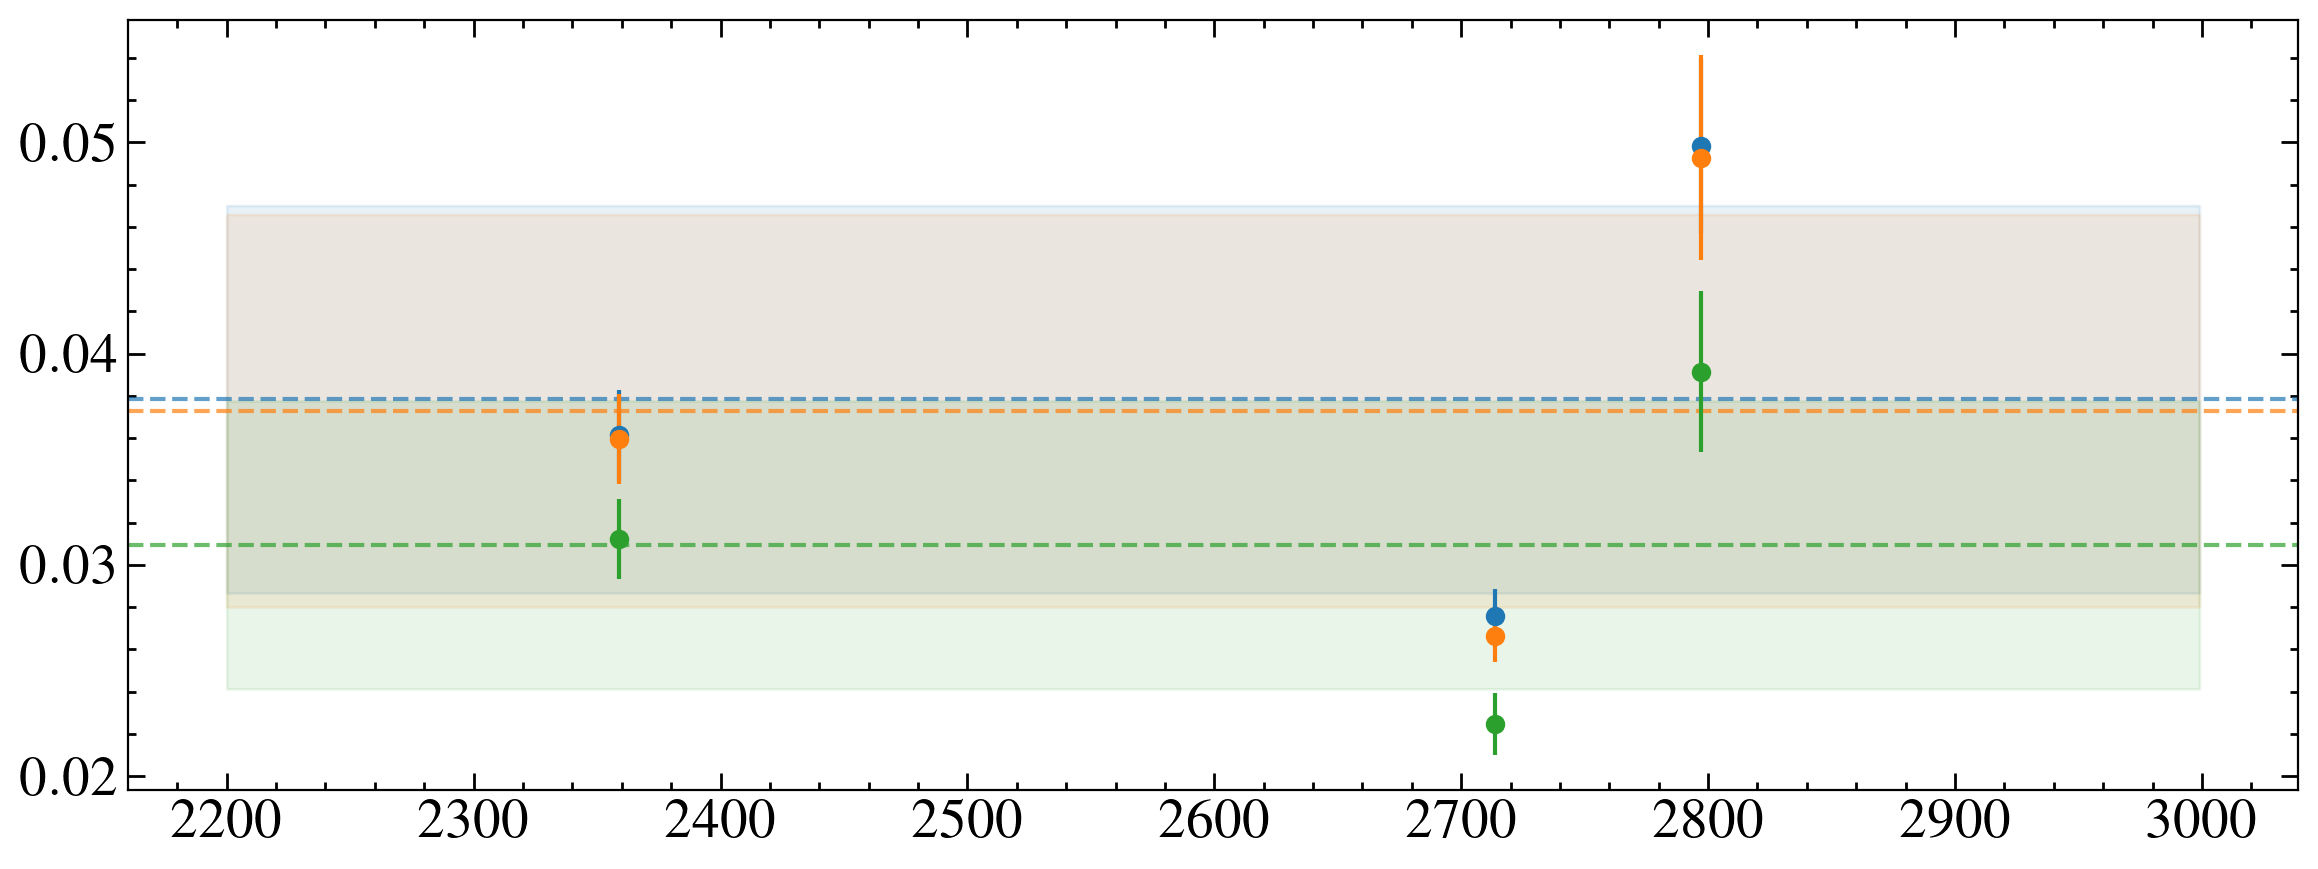

In [9]:
# prox_phots = []
# prox_phot_e = []


fig, ax = plt.subplots()


# what if i cut down the mg ii lines? Nope

# # mask = fx < 1e-15
# for bpw, bpf in zip(bpws, bpfs):
#     phot, phote = make_phot(bpw, bpf, wx[mask], fx[mask], e=ex[mask])
#     prox_phots.append(phot)
#     prox_phot_e.append(phote)
# prox_phots, prox_phot_e = np.array(prox_phots), np.array(prox_phot_e)


# ax.errorbar(phot_w, prox_phots, yerr=prox_phot_e, marker='o', ls='none', markeredgecolor='k', label = 'LHS-2686', zorder=12)
# markers = np.array(['p', 's', 'o'])
ratios = []
for i in range(3):
    

    # fig, ax = plt.subplot_mosaic([[0, 0, 0],[0,0,0], [1,1,1], [2,2,2], [2,2,2], [3,3,3]], sharex=True, figsize=(12, 10))
    phot_f = np.array([f225w_avs[i], f275w_avs[i], f280n_avs[i]])
    phot_e = np.array([f225w_aves[i], f275w_aves[i], f280n_aves[i]])

    ratio = phot_f /prox_phots
    ratio_e = ratio *((phot_e/phot_f)**2 + (prox_phot_e/prox_phots)**2)**0.5
    print(ratio)

    ax.errorbar(phot_w, ratio, yerr=ratio_e, marker='o', ls='none')
    ratios.append(ratio)

# mn, std = np.mean(ratios, axis=1), np.std(ratios, axis=1)
    ax.axhline(np.mean(ratio), ls ='--', alpha=0.7, c= 'C{}'.format(i))
    x = np.arange(2200, 3000, 1)
    ax.fill_between(x, (np.mean(ratio)-np.std(ratio)), (np.mean(ratio)+np.std(ratio)), alpha=0.1, color='C{}'.format(i))
    

    print(ratio[0]/ratio[1], ratio[0]/ratio[2], ratio[2]/ratio[1])
